### Improvements

Testing N=8: 100%|██████████| 100/100 [00:05<00:00, 17.35it/s]


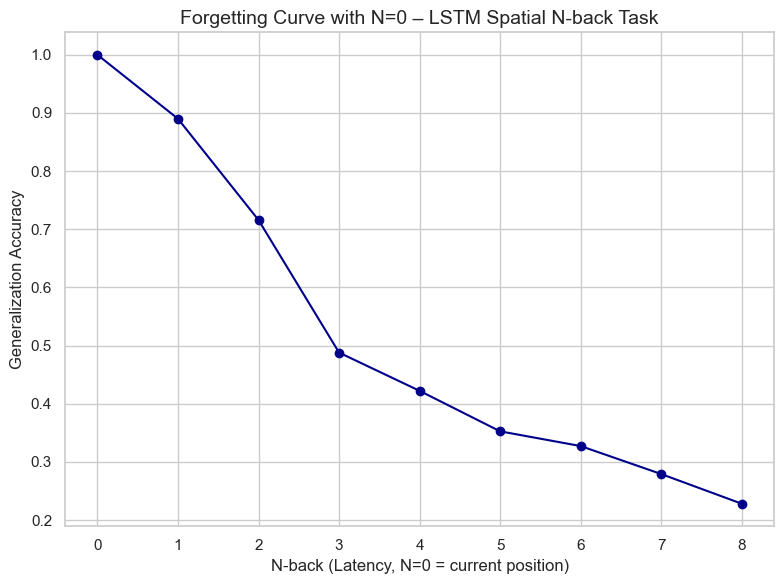

In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange

# Configuration
GRID_SIZE = 5
HIDDEN_SIZE = 128 # Increased hidden size for better capacity
INPUT_SIZE = 4 # We only input the action, the network learns the updated position implicitly (harder task)
OUTPUT_SIZE = GRID_SIZE**2
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
QUERY_PROB = 0.5 # Increased query probability for more frequent updates and thus better learning
MAX_STEPS = 50 # Reduced steps for faster training 
DROPOUT_RATE = 0.3


class MemoryLSTM(nn.Module):
    """Enhanced LSTM model with proper input handling"""
    def __init__(self, input_size: int, hidden_size: int, output_size: int, dropout: float = 0.3):
        super().__init__()
        # Input projection layer to handle concatenated features
        self.input_proj = nn.Linear(input_size + hidden_size, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, dropout=dropout)
        self.position_embedding = nn.Embedding(output_size, hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x: torch.Tensor, h, last_pos_idx=None):
        # x: action (batch, 4)
        if last_pos_idx is not None:
            pos_embed = self.position_embedding(last_pos_idx)  # (batch, hidden_size)
            x = torch.cat([x, pos_embed], dim=-1)  # (batch, 4 + hidden_size)
            x = self.input_proj(x)  # Project back to input_size
            
        out, h = self.lstm(x.unsqueeze(1), h)  # (batch, 1, hidden_size)
        return self.fc(out.squeeze(1)), h

def pos_to_onehot(pos: tuple[int, int], grid_size: int) -> np.ndarray:
    onehot = np.zeros(grid_size * grid_size)
    onehot[pos[0] * grid_size + pos[1]] = 1
    return onehot

def action_to_onehot(action: int) -> np.ndarray:
    onehot = np.zeros(4)
    onehot[action] = 1
    return onehot

def move(pos: tuple[int, int], action: int, grid_size: int) -> tuple[int, int]:
    x, y = pos
    if action == 0 and x > 0: x -= 1
    elif action == 1 and x < grid_size - 1: x += 1
    elif action == 2 and y > 0: y -= 1
    elif action == 3 and y < grid_size - 1: y += 1
    return (x, y)


class MemoryAgent:
    def __init__(self, N: int, grid_size: int = GRID_SIZE, hidden_size: int = HIDDEN_SIZE):
        self.N = N
        self.grid_size = grid_size
        self.model = MemoryLSTM(INPUT_SIZE, hidden_size, OUTPUT_SIZE, dropout=DROPOUT_RATE).to(DEVICE)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0005)
        self.criterion = nn.CrossEntropyLoss()

    def train(self, episodes: int = 500):
        self.model.train()
        for _ in trange(episodes, desc=f"Training N={self.N}"):
            pos = (0, 0)  # Always start from (0, 0)
            pos_idx = 0  # Initial position index
            history = deque(maxlen=self.N + 1)
            h = (torch.zeros(2, 1, HIDDEN_SIZE, device=DEVICE), 
                 torch.zeros(2, 1, HIDDEN_SIZE, device=DEVICE))

            for _ in range(MAX_STEPS):
                action = np.random.choice(4)
                next_pos = move(pos, action, self.grid_size)
                next_pos_idx = next_pos[0] * self.grid_size + next_pos[1]

                input_vec = torch.FloatTensor(action_to_onehot(action)).unsqueeze(0).to(DEVICE) # We're only inputting action, the network learns the updated position implicitly
                logits, h = self.model(input_vec, (h[0].detach(), h[1].detach()), 
                                     torch.LongTensor([pos_idx]).to(DEVICE))

                history.append((pos, pos_idx))
                pos, pos_idx = next_pos, next_pos_idx

                if len(history) > self.N and random.random() < QUERY_PROB:
                    target_pos, target_idx = history[-(self.N + 1)]
                    loss = self.criterion(logits, torch.LongTensor([target_idx]).to(DEVICE))

                    self.optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                    self.optimizer.step()

    def evaluate(self, episodes: int = 100) -> float:
        self.model.eval()
        correct, total = 0, 0

        with torch.no_grad():
            for _ in trange(episodes, desc=f"Testing N={self.N}"):
                pos = (0, 0)
                pos_idx = 0
                history = deque(maxlen=self.N + 1)
                h = (torch.zeros(2, 1, HIDDEN_SIZE, device=DEVICE),
                    torch.zeros(2, 1, HIDDEN_SIZE, device=DEVICE))

                for _ in range(MAX_STEPS):
                    action = np.random.choice(4)
                    next_pos = move(pos, action, self.grid_size)
                    next_pos_idx = next_pos[0] * self.grid_size + next_pos[1]

                    input_vec = torch.FloatTensor(action_to_onehot(action)).unsqueeze(0).to(DEVICE)
                    logits, h = self.model(input_vec, h, torch.LongTensor([pos_idx]).to(DEVICE))
                    
                    history.append((pos, pos_idx))
                    pos, pos_idx = next_pos, next_pos_idx

                    if len(history) > self.N and random.random() < QUERY_PROB:
                        target_pos, target_idx = history[-(self.N + 1)]
                        pred_idx = torch.argmax(logits).item()
                        correct += (pred_idx == target_idx)
                        total += 1
        return correct / total if total > 0 else 0


def run_memory_experiment(max_n: int = 8) -> list[float]:
    accuracies = []
    agent = MemoryAgent(N=0)
    agent.train()
    acc = agent.evaluate()
    accuracies.append(acc)

    for N in range(1, max_n + 1):
        agent.N = N
        agent.train()
        acc = agent.evaluate()
        accuracies.append(acc)
    return accuracies


def plot_results(forgetting_curve: list[float]):
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    plt.plot(range(0, len(forgetting_curve)), forgetting_curve, marker='o', color='darkblue')
    plt.title("Forgetting Curve with N=0 – LSTM Spatial N-back Task", fontsize=14)
    plt.xlabel("N-back (Latency, N=0 = current position)", fontsize=12)
    plt.ylabel("Generalization Accuracy", fontsize=12)
    plt.xticks(range(0, len(forgetting_curve)))
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    curve = run_memory_experiment()
    plot_results(curve)
